In [ ]:
!pip install nengo

In [ ]:
import nengo
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
time_per_data = 0.1
duration = 10.0
standard = 0.0

model = nengo.Network()
with model:
  x_data = np.random.uniform(-50, 50, 100)
  y_data = np.eye(2)[(x_data>standard).astype(np.int32)]

  input_node = nengo.Node(nengo.processes.PresentInput(x_data, time_per_data), size_out=1)
  target_node = nengo.Node(nengo.processes.PresentInput(y_data, time_per_data), size_out=2)
  input = nengo.Ensemble(100, 1)
  target = nengo.Ensemble(100, 2)

  nengo.Connection(input_node, input)
  nengo.Connection(target_node, target)

  pred = nengo.Ensemble(200, 2)
  pred_conn = nengo.Connection(input, pred, transform=[[1], [1]])

  input_node_p = nengo.Probe(input_node, synapse=0.01)
  target_node_p = nengo.Probe(target_node, synapse=0.01)
  input_p = nengo.Probe(input, synapse=0.01)
  pred_p = nengo.Probe(pred, synapse=0.01)
  target_p = nengo.Probe(target, synapse=0.01)

In [ ]:
with nengo.Simulator(model) as sim:
  sim.run(duration)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

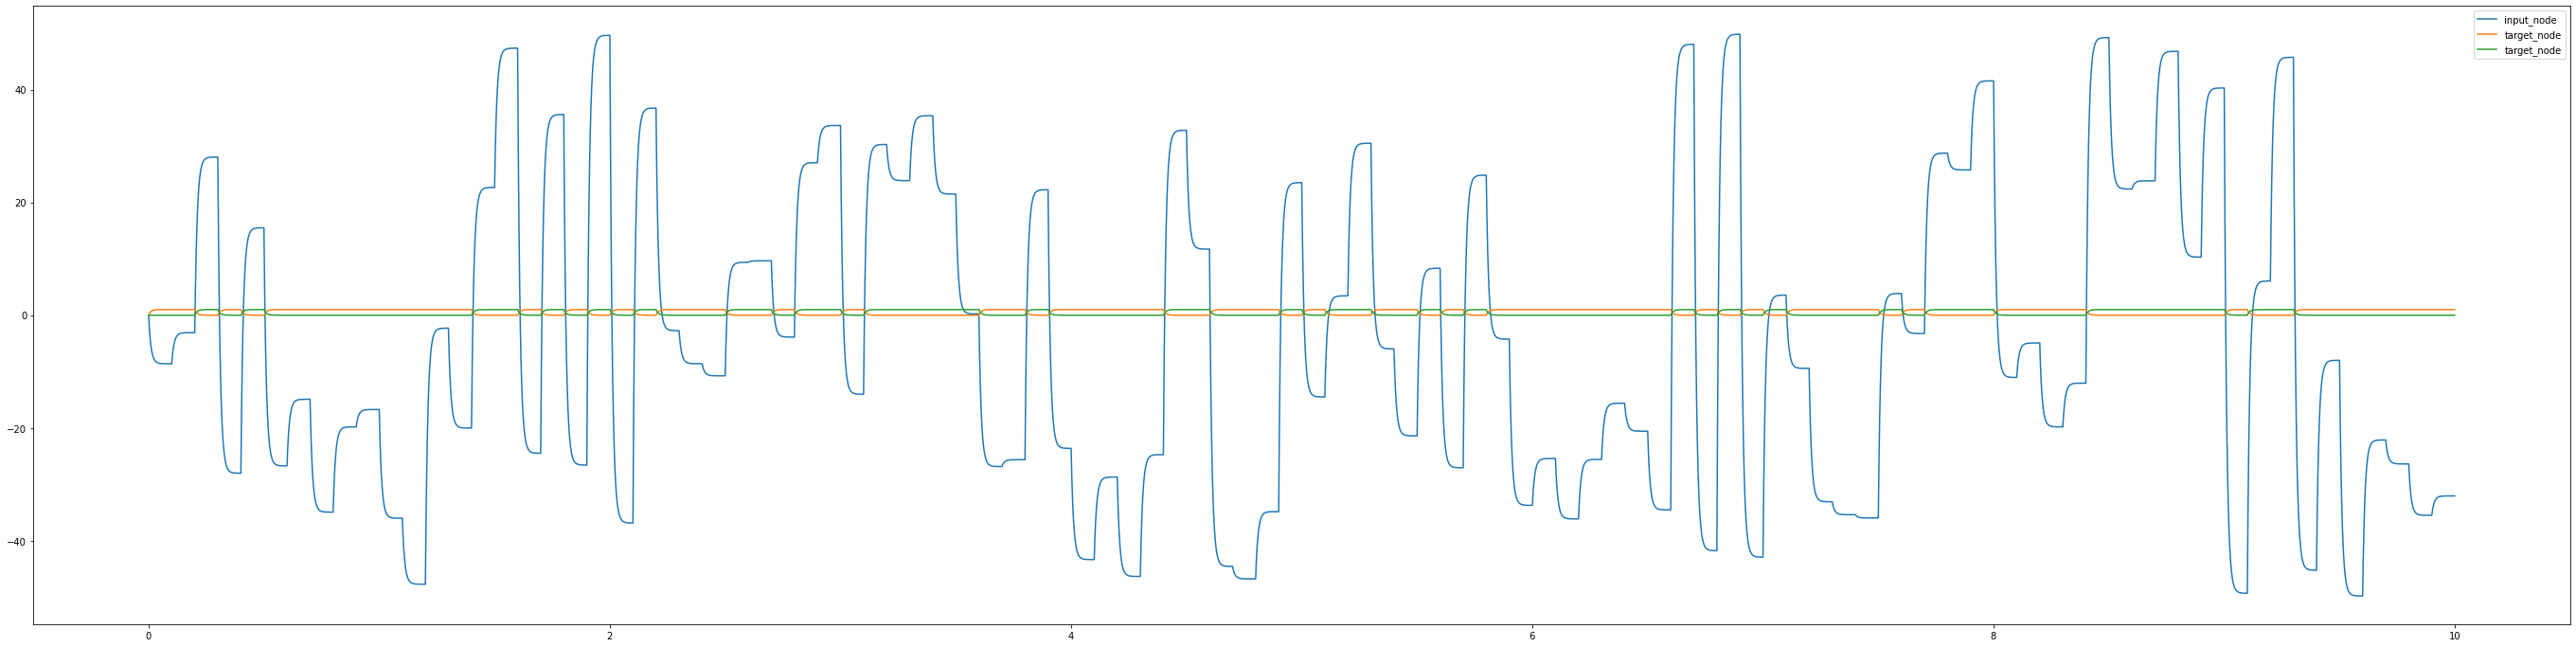

In [ ]:
plt.figure(figsize=(48, 12))
plt.plot(sim.trange(), sim.data[input_node_p], label="input_node")
plt.plot(sim.trange(), sim.data[target_node_p], label="target_node")
plt.legend()
plt.show()

# Train

In [ ]:
with model:
  err = nengo.Ensemble(200, dimensions=2)
  nengo.Connection(pred, err)
  nengo.Connection(target, err, transform=-1)

  pred_conn.learning_rule_type = nengo.learning_rules.PES()
  nengo.Connection(err, pred_conn.learning_rule)  

In [ ]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

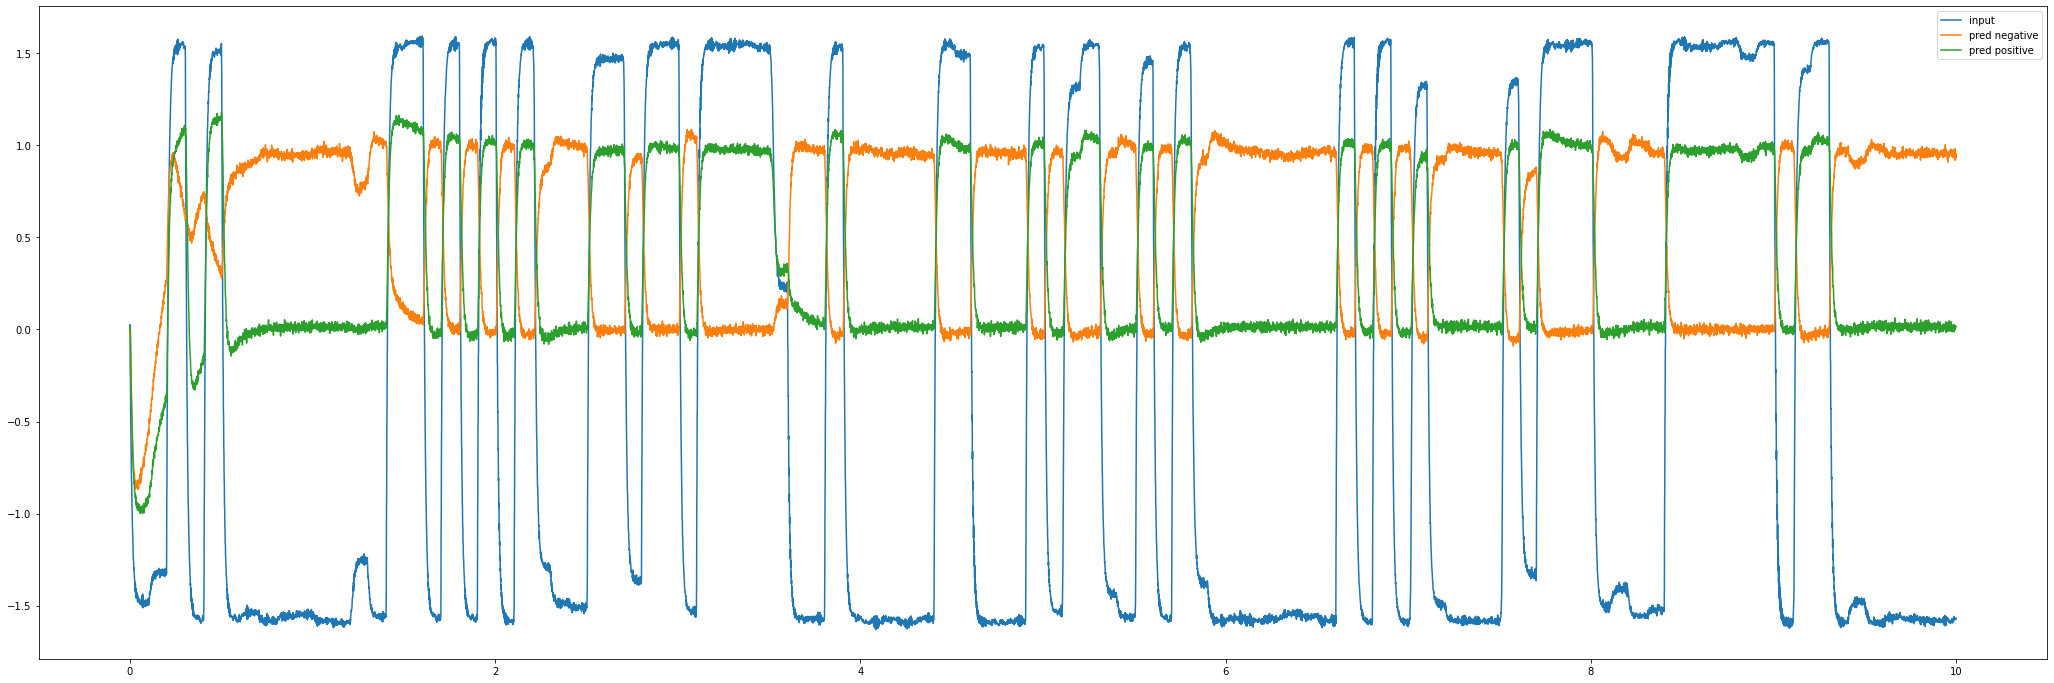

In [ ]:
plt.figure(figsize=(36, 12))
plt.plot(sim.trange(), sim.data[input_p], label="input")
plt.plot(sim.trange(), sim.data[pred_p][:, 0], label="pred negative")
plt.plot(sim.trange(), sim.data[pred_p][:, 1], label="pred positive")
# plt.plot(sim.trange(), sim.data[target_p][:, 0], label="target negative")
# plt.plot(sim.trange(), sim.data[target_p][:, 1], label="target positive")
plt.legend()
plt.show()

# Test

In [ ]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

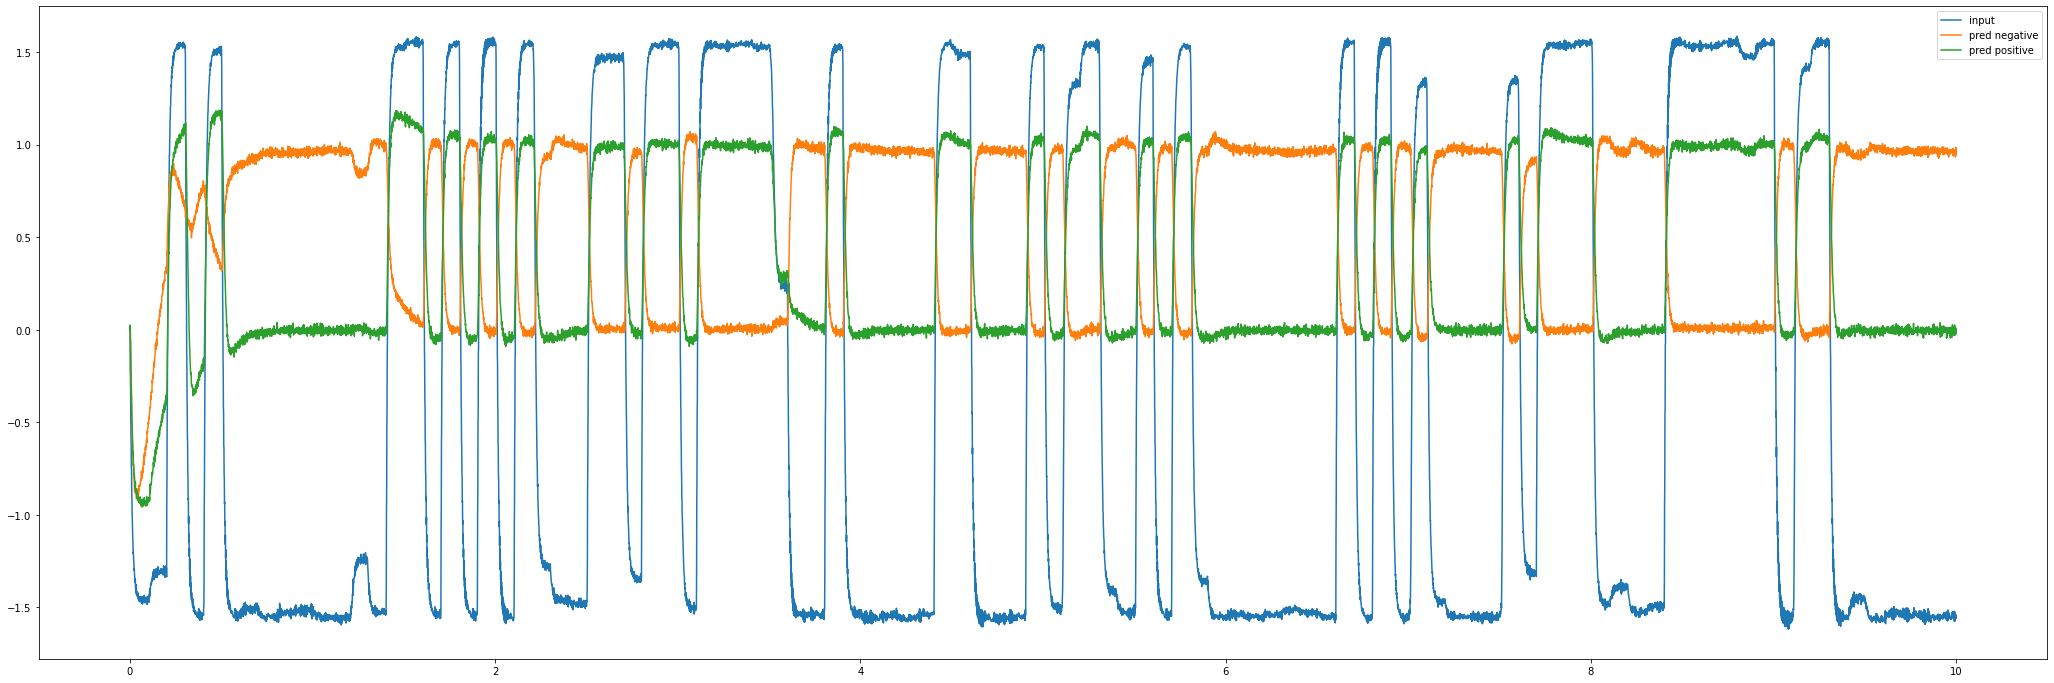

In [ ]:
plt.figure(figsize=(36, 12))
plt.plot(sim.trange(), sim.data[input_p], label="input")
plt.plot(sim.trange(), sim.data[pred_p][:, 0], label="pred negative")
plt.plot(sim.trange(), sim.data[pred_p][:, 1], label="pred positive")
# plt.plot(sim.trange(), sim.data[target_p][:, 0], label="target negative")
# plt.plot(sim.trange(), sim.data[target_p][:, 1], label="target positive")
plt.legend()
plt.show()

In [ ]:
sim.data[pred_p].argmax(-1).shape

preds = []
for i in range(0, 10000, 100):
  data = sim.data[pred_p][i:i+100]
  preds.append(data.mean(axis=0).argmax())

print(classification_report(y_data.argmax(-1), preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        39

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

